In [0]:
# 패키지 임포트
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


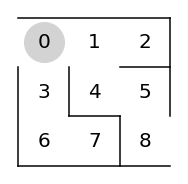

In [0]:
# 미로 생성
fig = plt.figure(figsize=(3, 3))

# 벽
plt.plot([0, 3], [3, 3], color='k')
plt.plot([0, 3], [0, 0], color='k')
plt.plot([0, 0], [0, 2], color='k')
plt.plot([3, 3], [1, 3], color='k')
plt.plot([1, 1], [1, 2], color='k')
plt.plot([2, 3], [2, 2], color='k')
plt.plot([2, 1], [1, 1], color='k')
plt.plot([2, 2], [0, 1], color='k')

# 숫자
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 원
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 눈금과 테두리 숨기기
plt.tick_params(axis='both', which='both', bottom='off', top= 'off',
        labelbottom='off', right='off', left='off', labelleft='off')
plt.box('off')

In [0]:
# 파라미터 θ의 초기값 준비
theta_0 = np.array([
    [np.nan, 1, 1, np.nan], # 0 상, 우, 하, 좌
    [np.nan, 1, 1, 1], # 1
    [np.nan, np.nan, np.nan, 1], # 2
    [1, np.nan, 1, np.nan], # 3
    [1, 1, np.nan, np.nan], # 4
    [np.nan, np.nan, 1, 1], # 5
    [1, 1, np.nan, np.nan], # 6
    [np.nan, np.nan, np.nan, 1]]) # 7

In [0]:
# 파라미터 θ를 정책으로 변환
def get_pi(theta):
    # 소프트맥스 함수로 변환
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta)
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

In [0]:
# 파라미터 θ의 초기값을 정책으로 변환
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [0]:
# 정책에 따라 행동 얻기
def get_a(pi, s):
    # 정책의 확률에 따라 행동을 반환
    return np.random.choice([0, 1, 2, 3], p=pi[s])

In [0]:
# 행동에 따라 다음 상태 얻기
def get_s_next(s, a):
    if a == 0: # 상
        return s - 3
    elif a == 1: # 우
        return s + 1
    elif a == 2: # 하
        return s + 3
    elif a == 3: # 좌
        return s - 1

In [0]:
# 1 에피소드 실행 후 이력 취득
def play(pi):
    s = 0 # 상태
    s_a_history = [[0, np.nan]] # 상태와 행동 이력
    
    # 에피소드 종료 시까지 반복
    while True:
        # 정책에 따라 행동 얻기
        a = get_a(pi, s)
        
        # 행동에 따라 다음 상태 얻기
        s_next = get_s_next(s, a)
        
        # 이력 갱신
        s_a_history[-1][1] = a     
        s_a_history.append([s_next, np.nan]) 
        
        # 종료 판정=
        if s_next == 8:
            break
        else:
            s = s_next
            
    return s_a_history

In [0]:
# 1 에피소드 실행 및 이력 확인
s_a_history = play(pi_0)
print(s_a_history)
print('1 에피소드의 스텝 수：{}'.format(len(s_a_history)+1))

[[0, 1], [1, 3], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 1], [7, 3], [6, 1], [7, 3], [6, 0], [3, 2], [6, 0], [3, 2], [6, 1], [7, 3], [6, 0], [3, 2], [6, 0], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 2], [4, 0], [1, 2], [4, 1], [5, 2], [8, nan]]
1 에피소드의 스텝 수：50


In [0]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 학습 계수
    total = len(s_a_history) - 1 # 골인 지점까지 걸린 총 스텝 수
    [s_count, a_count] = theta.shape # 상황 수, 행동 수

    # 파라미터 θ의 변화량 계산
    delta_theta = theta.copy()
    for i in range(0, s_count):
        for j in range(0, a_count):
            if not(np.isnan(theta[i, j])):
                # 특정한 상태에서 특정한 행동을 선택한 횟수
                sa_ij = [sa for sa in s_a_history if sa == [i, j]]
                n_ij = len(sa_ij)

                # 특정한 상태에서 무언가의 행동을 선택한 횟수
                sa_i = [sa for sa in s_a_history if sa[0] == i]
                n_i = len(sa_i)

                # 파라미터 θ의 변화량
                delta_theta[i, j] = (n_ij + pi[i, j] * n_i) / total

    # 파라미터 θ 갱신
    return theta + eta * delta_theta

In [0]:
stop_epsilon = 10**-3 # 임곗값
theta = theta_0 # 파라미터 θ
pi = pi_0 # 정책

# 에피소드를 반복해서 실행하며 학습
for episode in range(1000):
    # 1 에피소드 실행 후 이력 얻기
    s_a_history = play(pi)
    
    # 파라미터 θ 갱신
    theta = update_theta(theta, pi, s_a_history)
    
    # 정책 갱신
    pi_new = get_pi(theta)
    
    # 정책 변화량
    pi_delta = np.sum(np.abs(pi_new-pi))
    pi = pi_new    
    
    # 출력
    print('에피소드: {}, 스텝： {}, 정책 변화량: {:.4f}'.format(
        episode, len(s_a_history)-1, pi_delta))
    
    # 완료 판정
    if pi_delta < stop_epsilon: # 정책 변화량이 입계값 이하
        break

에피소드: 0, 스텝： 12, 정책 변화량: 0.0162
에피소드: 1, 스텝： 10, 정책 변화량: 0.0196
에피소드: 2, 스텝： 16, 정책 변화량: 0.0096
에피소드: 3, 스텝： 36, 정책 변화량: 0.0150
에피소드: 4, 스텝： 86, 정책 변화량: 0.0120
에피소드: 5, 스텝： 48, 정책 변화량: 0.0088
에피소드: 6, 스텝： 28, 정책 변화량: 0.0108
에피소드: 7, 스텝： 90, 정책 변화량: 0.0060
에피소드: 8, 스텝： 12, 정책 변화량: 0.0217
에피소드: 9, 스텝： 8, 정책 변화량: 0.0214
에피소드: 10, 스텝： 14, 정책 변화량: 0.0119
에피소드: 11, 스텝： 44, 정책 변화량: 0.0090
에피소드: 12, 스텝： 78, 정책 변화량: 0.0115
에피소드: 13, 스텝： 52, 정책 변화량: 0.0139
에피소드: 14, 스텝： 28, 정책 변화량: 0.0157
에피소드: 15, 스텝： 40, 정책 변화량: 0.0080
에피소드: 16, 스텝： 26, 정책 변화량: 0.0173
에피소드: 17, 스텝： 10, 정책 변화량: 0.0294
에피소드: 18, 스텝： 12, 정책 변화량: 0.0181
에피소드: 19, 스텝： 70, 정책 변화량: 0.0109
에피소드: 20, 스텝： 154, 정책 변화량: 0.0083
에피소드: 21, 스텝： 20, 정책 변화량: 0.0125
에피소드: 22, 스텝： 8, 정책 변화량: 0.0316
에피소드: 23, 스텝： 38, 정책 변화량: 0.0136
에피소드: 24, 스텝： 8, 정책 변화량: 0.0291
에피소드: 25, 스텝： 28, 정책 변화량: 0.0153
에피소드: 26, 스텝： 12, 정책 변화량: 0.0168
에피소드: 27, 스텝： 62, 정책 변화량: 0.0123
에피소드: 28, 스텝： 90, 정책 변화량: 0.0046
에피소드: 29, 스텝： 8, 정책 변화량: 0.0325
에피소드: 30, 스텝： 70, 정책 변화

In [0]:
# 애니메이션을 정기적으로 처리하는 함수
def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state / 3))
    return circle

# 애니메이션 표시
anim = animation.FuncAnimation(fig, animate, \
        frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())